# WONC-DG Numerical Experiments

## Load code of WONC-FD method

In [9]:
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import itertools
import pywt
from joblib import Parallel, delayed
import optuna
import random

In [10]:
def intervals_zeros(arr: np.ndarray,
                    intervals: list = None,
                    num: int = 0) -> list:
    """
    Returns a binned array

    Splits an array into intervals up to points,
    which are specified in intervals or into n parts,
    which are specified in num

    :param arr: source array to split into intervals
    :param intervals: an array of intervals to which you want to split
    :param num: the number of intervals to split into
    :return: Returns a binned array
    """

    if not (num == 0):
        res = [arr[d: d + num] for d in range(0, len(arr), num)]
    else:
        res = []
        intervals = sorted(intervals)
        temp = []
        k = 0
        for i in range(len(arr)):
            if (arr[i] < intervals[k]) or (arr[i] > intervals[k] and k == len(intervals) - 1):
                temp.append(arr[i])
            else:
                temp.append(arr[i])
                res.append(temp)
                temp = []
                if k + 1 < len(intervals):
                    k += 1
        res.append(temp)

    result = []

    for i in range(len(res)):
        temp = np.array(res[i])
        if len(temp) < len(arr):
            lenght = sum([len(j) for j in res[:i]])
            zeros = np.zeros(lenght)
            if len(zeros) > 0:
                temp = np.concatenate((zeros, temp))
            zeros = np.zeros(len(arr) - len(temp))
            if len(zeros) > 0:
                temp = np.concatenate((temp, zeros))
        result.append(temp)

    arr = result

    return arr


def haar(x: np.ndarray,
         y: np.ndarray,
         a: float,
         b: float,
         c: float,
         k: float) -> list:
    """
    Returns the haar function of f(x) and x

    Returns the haar function with the specified function height from -k to k
    on the interval from a to b and from b to c,
    changing the arrays of the definition area - f(x) and the range of values - x

    :param x: initial array x
    :param y: initial array f(x)
    :param a: start of first interval
    :param b: the end of the first and the beginning of the second interval
    :param c: end of second interval
    :param k: haar magnitude factor in y
    :return: returns the haar function of f(x) - y and x
    """

    result = []

    for i in range(len(x)):
        if a <= x[i] < b:
            result.append(k)
        elif b <= x[i] < c:
            result.append(-k)
        else:
            result.append(y[i])

    return result


def haar_1(x: np.ndarray,
           y: np.ndarray,
           a: float,
           b: float,
           k: float) -> list:
    """
    Returns single step haar function of f(x) and x

    Returns a single-stage haar function with the specified function height from -k to k
    on the interval from a to b,
    changing the arrays of the definition area - f(x) - y and the range of values - x

    :param x: initial array x
    :param y: initial array f(x)
    :param a: start of interval
    :param b: end of the interval
    :param k: haar magnitude factor in y
    :return: returns single step haar function of f(x) and x
    """

    result = []

    for i in range(len(x)):
        if a <= x[i] <= b:
            result.append(k)
        else:
            result.append(y[i])

    return result


def error_exp(x: np.ndarray,
              y: np.ndarray,
              a: float,
              b: float,
              t: float = 0,
              delta: float = 0.2,
              epsilon: float = 0.0001) -> list:
    """
    Returns exponent over interval

    Returns an exponential error function on the interval from a to b,
    changing the range array - f(x) - y and the range array - x

    :param x: initial array x
    :param y: initial array f(x)
    :param a: start of first interval
    :param b: the end of the second interval
    :param t: exponent attribute
    :param delta: exponent attribute increment step
    :param epsilon: value to compare two float values
    :return: returns exponent over interval
    """

    result = []

    for i in range(len(x)):
        if a <= x[i] < b:
            result.append(exp(t - 1) / 100)
            t += delta
        elif abs(x[i] - b) <= epsilon:
            result.append(0)
        else:
            result.append(y[i])

    return result


def error_minus_exp(x: np.ndarray,
                    y: np.ndarray,
                    a: float,
                    b: float,
                    c: float,
                    k: float,
                    t: float = 0,
                    delta: float = 0.15,
                    epsilon: float = 0.0001) -> list:
    """
    Returns minus exponent over interval

    Returns the error function of the opposite exponent
    over the interval from b to c with a splash in a, c
    hanging the range array - f(x) - y and the range array - x

    :param x: initial array x
    :param y: initial array f(x)
    :param a: start of first interval
    :param b: the end of the first and the beginning of the second interval
    :param c: the end of the second interval
    :param k: error magnitude factor in y
    :param t: exponent attribute
    :param delta: exponent attribute increment step
    :param epsilon: value to compare two float values
    :return: returns minus exponent over interval
    """

    result = []

    for i in range(len(x)):
        if b <= x[i] <= c:
            result.append(-exp(t) / 400)
            t += delta
        elif abs(x[i] - a) <= epsilon:
            result.append(k)
        else:
            result.append(y[i])

    return result


def error_inv_exp(x: np.ndarray,
                  y: np.ndarray,
                  a: float,
                  b: float,
                  c: float,
                  k: float,
                  t: float = 0,
                  delta: float = 0.1,
                  epsilon: float = 0.0001) -> list:
    """
    Returns the inverse exponent over an interval

    Returns the inverse exponential error function
    from b to c with a splash in a,
    changing the range array - f(x) - y and the range array - x

    :param x: initial array x
    :param y: initial array f(x)
    :param a: start of first interval
    :param b: the end of the first and the beginning of the second interval
    :param c: the end of the second interval
    :param k: error magnitude factor in y
    :param t: exponent attribute
    :param delta: exponent attribute increment step
    :param epsilon: value to compare two float values
    :return: returns the inverse exponent over an interval
    """

    result = []

    for i in range(len(x)):
        if b <= x[i] <= c:
            result.append(1 / exp(t - 2))
            t += delta
        elif abs(x[i] - a) <= epsilon:
            result.append(k)
        else:
            result.append(y[i])

    return result


def error_inv_exp_plus(x: np.ndarray,
                       y: np.ndarray,
                       a: float,
                       b: float,
                       c: float,
                       k: float,
                       t: float = 0,
                       delta: float = 0.1,
                       epsilon: float = 0.0001) -> list:
    """
    Returns the inverse exponent with a shift up over an interval

    Returns the inverse exponential error function with a shift
    from b to c with a splash in a,
    changing the range array - f(x) - y and the range array - x

    :param x: initial array x
    :param y: initial array f(x)
    :param a: start of first interval
    :param b: the end of the first and the beginning of the second interval
    :param c: the end of the second interval
    :param k: error magnitude factor in y
    :param t: exponent attribute
    :param delta: exponent attribute increment step
    :param epsilon: value to compare two float values
    :return: returns the inverse exponent with a shift up over an interval
    """

    result = []

    for i in range(len(x)):
        if b <= x[i] <= c:
            result.append((-exp(t) + 500) / 100)
            t += delta
        elif abs(x[i] - a) <= epsilon:
            result.append(k)
        else:
            result.append(y[i])

    return result


def algb_3(x: np.ndarray,
           y: np.ndarray,
           a: float,
           b: float,
           c: float,
           d: float,
           i0: float,
           i1: float,
           t: float = -1.7,
           delta: float = 0.03) -> list:
    """
    Returns a polynomial of degree 3 over an interval

    Returns a polynomial of degree 3
    from i0 to i1 withwith coefficients a,b,c,d,
    changing the range array - f(x) - y and the range array - x

    :param x: initial array x
    :param y: initial array f(x)
    :param a: first polynomial coefficient
    :param b: second polynomial coefficient
    :param c: third polynomial coefficient
    :param d: fourth polynomial coefficient
    :param i0: start of first interval
    :param i1: end of the interval
    :param t: polynomial attribute
    :param delta: polynomial attribute increment step
    :return: returns a polynomial of degree 3 over an interval
    """

    result = []

    for i in range(len(x)):
        if i0 <= x[i] <= i1:
            result.append(a * t ** 3 + b * t ** 2 + c * t + d)
            t += delta
        else:
            result.append(y[i])

    return result


def transform(x: np.ndarray,
              y: np.ndarray,
              sx: float,
              sy: float) -> np.ndarray:
    """
    Returns the transformed matrix

    Returns the x-axis shrink or stretch matrix
    (with the x-axis stretch factor - sx)
    and y (with the y-axis stretch factor - sy)

    :param x: initial array x
    :param y: initial array y
    :param sx: compression/expansion ratio x
    :param sy: compression/expansion ratio y
    :return: returns the transformed matrix
    """

    y = np.array([x, y])
    transform_matrix = np.array([[sx, 0], [0, sy]])
    y_transformed = np.dot(transform_matrix, y)

    return y_transformed


def Error_signal(signal: str,
                 x: np.ndarray,
                 a: float,
                 t: float) -> np.ndarray:
    """
    Returns an array of y given the function and stretch factors

    Returns an array with the selected error function
    from the list of errors with amplitude factor (y-axis stretch)
    and time stretch (x-axis stretch)

    :param signal: error input function
    :param x: initial array x
    :param a: compression/expansion ratio amplitude (y)
    :param t: compression/expansion ratio time (x)
    :return: returns an array of y given the function and stretch factors
    """

    y = np.zeros(len(x))
    if signal == "haar":
        y = haar(x, y, 0.075, 0.1, 0.125, 3)
    elif signal == "haar1":
        y = haar_1(x, y, 0.05, 0.15, 3)
    elif signal == "exp":
        y = error_exp(x, y, 0.065, 0.1)
    elif signal == "-exp":
        y = error_minus_exp(x, y, 0.09, 0.1, 0.15, 0)
    elif signal == "Invexp":
        y = error_inv_exp(x, y, 0.09, 0.1, 0.15, 0.7)
    elif signal == "Invexp+":
        y = error_inv_exp_plus(x, y, 0.09, 0.1, 0.15, 0.7)
    elif signal == "algb":
        y = algb_3(x, y, 1, 1, 1, 0, 0.05, 0.15)

    x_arr, y_arr = np.array(transform(x, y, t, a), dtype=np.float32)

    return y_arr


def create_multierror_dataset(quan_in: int,
                              power_quan_in: int,
                              time_in: float = 1,
                              errors: list = ["haar", "haar1", "exp", "-exp", "Invexp", "Invexp+", "algb"],
                              signal_in: str = "sin") -> pd.DataFrame:
    """
    Returns a dataset of y and x for the specified number of failures and different signal amplitudes

    Returns a DataFrame over time_in with the number of random errors quan_in,
    the amount of random amplitude of the base signal (based on a sine wave) power_quan_in
    and with errors from the errors list

    :param quan_in: number of failures
    :param power_quan_in: the number of signals of different amplitudes
    :param time_in: signal time
    :param errors: set of errors
    :param signal_in: input signal (according to the standard - sinusoid)
    :return: returns a dataset of y and x for the specified number of failures and different signal amplitudes
    """

    x = np.arange(0, time_in, 0.001, dtype=np.float32)
    start = time_in / 1000

    t_quan = np.random.uniform(start, time_in - 0.2, quan_in)
    rand_err = np.random.choice(errors, quan_in)
    rand_max_ampl_pom = np.random.uniform(1, 25, quan_in)

    arr_errors = []
    for i, err in enumerate(rand_err):
        arr_error = np.concatenate((np.zeros(round(t_quan[i] / 0.001)), Error_signal(err, x, rand_max_ampl_pom[i], 1)))[
                    :len(x)]
        arr_errors.append(arr_error)

    arr_signal = np.array(intervals_zeros(x, num=round(len(x) / power_quan_in)))
    rand_max_ampl_signal = np.random.uniform(1, 25, power_quan_in)

    for i in range(power_quan_in):
        arr_signal[i] = transform(arr_signal[i], np.sin(100 * np.pi * arr_signal[i]), 1, rand_max_ampl_signal[i])[1]

    result_signal = np.sum(arr_signal, axis=0)
    result_errors = np.sum(arr_errors, axis=0)
    result = result_signal + result_errors

    dataset = {"x": x,
               "y": result}

    dataset = pd.DataFrame(dataset)

    return dataset

In [11]:
def filter_faults(signal: np.ndarray, faults: np.ndarray, h: float = 0.001) -> np.ndarray:
    """
    Returns an array of faults by threshold

    Returns an array of faults by threshold

    :param signal: signal of wave
    :param faults: array of faults
    :param h: threshold
    :return: returns an array of faults
    """

    faults_mean = np.absolute(signal[faults])[0]
    arr = np.array([])
    for i in range(len(faults)):
        if abs(abs(signal[faults[i]]) - faults_mean) > h:
            arr = np.append(arr, faults[i])

    return arr


def detect_faults(signal: np.ndarray, min_threshold: float = 0.1, max_threshold: float = 25) -> tuple:
    """
    Returns an array of peaks by threshold

    Returns an array of peaks by threshold

    :param signal: signal of wave
    :param min_threshold: min threshold
    :param max_threshold: max threshold
    :return: returns an array of peaks
    """

    peaks = scipy.signal.find_peaks(abs(signal), prominence=(min_threshold, max_threshold))
    return peaks


def intervals_errors(signal: np.ndarray,
                     wavelet: str = 'db20',
                     level: int = 3,
                     epsilon: int = 2,
                     min_threshold: float = 0.1,
                     max_threshold: float = 25,
                     h: float = 1e-6) -> list:
    """
    Generate list of intervals for errors

    :param signal: array of signal wave
    :param wavelet: wavelet for wavelet decomposition
    :param level: level of decomposition
    :param epsilon: epsilon
    :param min_threshold: min threshold
    :param max_threshold: max threshold
    :param h: h
    :return: list of intervals
    """

    coeffs = pywt.wavedec(signal, wavelet, level=level)

    cf_lvl = coeffs[level]
    peaks = detect_faults(cf_lvl, min_threshold, max_threshold)
    faults_index = filter_faults(cf_lvl, peaks[0], h)
    eps_peaks = [peak - epsilon for peak in peaks[0]]

    intervals = list(itertools.combinations(eps_peaks, 2))

    return intervals


def clean_signal(signal: np.ndarray) -> np.ndarray:
    """
    Function for cleaning signal

    :param signal: signal of x and y values
    :return: new signal of y
    """

    vals, counts = np.unique(signal["y"], return_counts=True)
    Ampl = vals[np.argmax(counts)]
    y = signal["y"] - abs(Ampl) * np.sin(100 * np.pi * signal["x"])

    return y


def vis_errors_intervals(y: np.ndarray, intervals: list) -> None:
    """
    Visualize plot of signal with errors intervals

    :param y: signal
    :param intervals: intervals of errors
    """

    for err in intervals:
        plt.plot(y)
        color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        plt.axvspan((err[0] * 2), (err[1] * 2), alpha=0.3, color=color, label='Выделенный интервал')
        plt.show()

In [12]:
def MSE(y: np.ndarray, y_pred: np.ndarray) -> float:
    """
    MSE function

    :param y: array of dots
    :param y_pred: array of dots
    :return: MSE, float
    """

    return np.mean(np.square(y - y_pred))


def pad_array(arr: np.ndarray, length: int) -> np.ndarray:
    """
    Function for pad an array

    :param arr: array
    :param length: length for new array
    :return: new array
    """

    current_len = len(arr)
    if current_len >= length:
        return arr
    else:
        pad_len = length - current_len
        left_len = pad_len // 2
        right_len = pad_len - left_len
        arr = np.pad(arr,
                     (left_len, right_len),
                     mode='constant',
                     constant_values=0)

    return arr


def resize_vector(vector: np.ndarray, new_size: int) -> np.ndarray:
    """
    Resize vector

    :param vector: array
    :param new_size: new size
    :return: array with new size
    """

    old_size = len(vector)

    if new_size == old_size:
        return vector

    if new_size > old_size:
        indices = np.linspace(0, old_size - 1, new_size, dtype=float)
        return np.interp(indices, np.arange(old_size), vector)

    indices = np.linspace(0, old_size - 1, new_size, dtype=float)
    resized_vector = np.zeros(new_size)

    for i in range(new_size):
        start_index = int(indices[i])
        end_index = start_index + 1 if i < new_size - 1 else old_size

        resized_vector[i] = np.mean(vector[start_index:end_index])

    return resized_vector


def mse_classification(y: np.ndarray,
                       errors: list = ["haar", "haar1", "exp", "-exp", "Invexp", "Invexp+", "algb"],
                       leng: int = 1000,
                       epsilon: float = 0.01,
                       n: float = 0.98) -> list:
    """
    MSE classification

    :param y: dots of signal with error
    :param errors: list of errors
    :param leng: length of y
    :param epsilon: small number to check proximity to 0
    :param n: percentage of the size of the array with 0 to ignore it
    :return: array with class of function and MSE
    """

    if len(y) <= leng * 0.05 or sum(1 for point in y if abs(point) < epsilon) > len(y) * n:
        return ["Bad signal", "Nan"]

    result = np.array([])
    x = np.linspace(0, 1, len(y))
    ampl = 1
    size_values = np.arange(len(y), 2 * len(y), 10)
    shifts = np.arange(-len(y), len(y), 1)

    for err in errors:
        mse_err = 1e5
        for s in size_values:
            for shift in shifts:
                if shift >= 0:
                    Error = np.resize(resize_vector(Error_signal(err, x, ampl, 1), s), (1, len(y)))[0]
                    arr_error = np.concatenate((np.zeros(shift), Error))[:len(x)]
                else:
                    Error = np.resize(resize_vector(Error_signal(err, x, ampl, 1), s), (1, len(y)))[0]
                    arr_error = np.concatenate((Error, np.zeros(-shift)))[-len(x):]

                # Аппроксимация сигнала с использованием метода наименьших квадратов
                features_matrix = np.vstack((np.ones(len(x)), arr_error)).T
                coefficients, _, _, _ = np.linalg.lstsq(features_matrix, y, rcond=None)
                approximated_signal = np.dot(features_matrix, coefficients)

                mse = MSE(y, approximated_signal)
                if mse < mse_err:
                    mse_err = mse
        result = np.append(result, mse_err)

    result = [errors[np.argmin(result)], result[np.argmin(result)]]

    return result


def math_classification_brute(y: np.ndarray,
                              errors: list = ["haar", "haar1", "exp", "-exp", "Invexp", "Invexp+", "algb"],
                              leng: int = 1000,
                              epsilon: float = 0.01,
                              n: float = 0.98) -> list:
    """
    Math classification brute

    :param y: dots of signal with error
    :param errors: list of errors
    :param leng: length of y
    :param epsilon: small number to check proximity to 0
    :param n: percentage of the size of the array with 0 to ignore it
    :return: array with class of function and MSE
    """

    if len(y) <= leng * 0.05 or sum(1 for point in y if abs(point) < epsilon) > len(y) * n:
        return ["Bad signal", "Nan"]

    y = pad_array(y, leng)
    result = np.array([])
    x = np.linspace(0, 1, len(y))
    ampl = 1
    size_values = np.arange(len(y) - 10, len(y) + 10, 1)
    shifts = np.arange(-len(y), len(y), 1)

    for err in errors:
        mse_err = 1e5
        for s in size_values:
            for shift in shifts:
                Error = np.resize(resize_vector(Error_signal(err, x, ampl, 1), s), (1, len(y)))[0]
                if shift >= 0:
                    arr_error = np.concatenate((np.zeros(shift), Error))[:len(x)]
                else:
                    arr_error = np.concatenate((Error, np.zeros(-shift)))[-len(x):]

                # Аппроксимация сигнала с использованием метода наименьших квадратов
                features_matrix = np.vstack((np.ones(len(x)), arr_error)).T
                coefficients, _, _, _ = np.linalg.lstsq(features_matrix, y, rcond=None)
                approximated_signal = np.dot(features_matrix, coefficients)

                mse = MSE(y, approximated_signal)
                if mse < mse_err:
                    mse_err = mse
        result = np.append(result, mse_err)

    result = [errors[np.argmin(result)], result[np.argmin(result)]]

    return result


def objective_function(params: list, y: np.ndarray, error: str) -> float:
    """
    Objective function for minimization

    :param params: array of params
    :param y: dots of signal with error
    :param error: error
    :return: MSE of function with that params
    """

    size, shift = params
    size, shift = int(size), int(shift)

    x = np.linspace(0, 1, len(y))
    ampl = 1

    if shift >= 0:
        Error = np.resize(resize_vector(Error_signal(error, x, ampl, 1), size), (1, len(y)))[0]
        arr_error = np.concatenate((np.zeros(shift), Error))[:len(x)]
    else:
        Error = np.resize(resize_vector(Error_signal(error, x, ampl, 1), size), (1, len(y)))[0]
        arr_error = np.concatenate((Error, np.zeros(-shift)))[-len(x):]

    features_matrix = np.vstack((np.ones(len(x)), arr_error)).T
    coefficients, _, _, _ = np.linalg.lstsq(features_matrix, y, rcond=None)
    approximated_signal = np.dot(features_matrix, coefficients)

    mse = MSE(y, approximated_signal)

    return mse


def math_classification(y: np.ndarray,
                        errors: list = ["haar", "haar1", "exp", "-exp", "Invexp", "Invexp+", "algb"],
                        leng: int = 1000,
                        epsilon: float = 0.01,
                        n: float = 0.98,
                        method: str = 'Nelder-Mead',
                        maxfev: int = 3000,
                        iters: int = 20) -> list:
    """
    Math classification

    :param y: dots of signal with error
    :param errors: list of errors
    :param leng: length of y
    :param epsilon: small number to check proximity to 0
    :param n: percentage of the size of the array with 0 to ignore it
    :param method: method of optimization
    :param maxfev: max iterations
    :return: array with class of function and MSE
    """

    if len(y) <= leng * 0.05 or sum(1 for point in y if abs(point) < epsilon) > len(y) * n:
        return ["Bad signal", "Nan"]

    y = pad_array(y, leng)
    result = np.array([])
    bounds = [(len(y) - 10, len(y) + 10), (-len(y), len(y))]

    size_values = np.arange(len(y) - 10, len(y) + 10, 1)
    shifts = np.arange(-len(y), len(y), 1)

    selected_indices_size = np.linspace(0, len(size_values) - 1, iters).astype(int)
    selected_indices_shift = np.linspace(0, len(shifts) - 1, iters).astype(int)

    size = size_values[selected_indices_size]
    shift = shifts[selected_indices_shift]

    for err in errors:
        best_loss = np.inf

        for i in range(iters):
            init_params = [size[i], shift[i]]
            res = scipy.optimize.minimize(objective_function,
                                          init_params,
                                          args=(y, err),
                                          method=method,
                                          bounds=bounds,
                                          options={'maxfev': maxfev})
            if res.fun < best_loss:
                best_loss = res.fun
        result = np.append(result, best_loss)

    #result = [errors[np.argmin(result)], result[np.argmin(result)]]
    result = [[errors[err], result[err]] for err in range(len(result))]

    return result

In [13]:
def objective_function(trial, y: np.ndarray, error: str):
    """
    Objective function for optuna optimizer

    :param trial: optuna trial
    :param y: dots of signal with error
    :param error: error
    :return: MSE of function with that params
    """

    size = trial.suggest_int('size', len(y) - 10, len(y) + 10)
    shift = trial.suggest_int('shift', -len(y), len(y))

    x = np.linspace(0, 1, len(y))
    ampl = 1

    if shift >= 0:
        Error = np.resize(resize_vector(Error_signal(error, x, ampl, 1), size), (1, len(y)))[0]
        arr_error = np.concatenate((np.zeros(shift), Error))[:len(x)]
    else:
        Error = np.resize(resize_vector(Error_signal(error, x, ampl, 1), size), (1, len(y)))[0]
        arr_error = np.concatenate((Error, np.zeros(-shift)))[-len(x):]

    features_matrix = np.vstack((np.ones(len(x)), arr_error)).T
    coefficients, _, _, _ = np.linalg.lstsq(features_matrix, y, rcond=None)
    approximated_signal = np.dot(features_matrix, coefficients)

    mse = MSE(y, approximated_signal)
    return mse


def optimize_params(y: np.ndarray, error: str, iters: int):
    """
    Optimize params by optuna function

    :param y: dots of signal with error
    :param error: error
    :param iters: number of iterations for optimization
    :return: best value of optuna optimization
    """

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
    study.optimize(lambda trial: objective_function(trial, y, error), n_trials=iters)
    return study.best_value


def optuna_classification_parallel(y: np.ndarray,
                                   errors: list = ["haar", "haar1", "exp", "-exp", "Invexp", "Invexp+", "algb"],
                                   leng: int = 1000,
                                   epsilon: float = 0.01,
                                   n: float = 0.98,
                                   iters: int = 100) -> list:
    """Optuna math classification parallel

    :param y: dots of signal with error
    :param errors: list of errors
    :param leng: length of y
    :param epsilon: small number to check proximity to 0
    :param n: percentage of the size of the array with 0 to ignore it
    :return: array with class of function and MSE
    """

    if len(y) <= leng * 0.05 or sum(1 for point in y if abs(point) < epsilon) > len(y) * n:
        return ["Bad signal", "Nan"]

    y = pad_array(y, leng)

    best_losses = Parallel(n_jobs=-1)(delayed(optimize_params)(y, error, iters) for error in errors)
    best_loss_idx = np.argmin(best_losses)
    best_error = errors[best_loss_idx]
    best_loss = best_losses[best_loss_idx]

    result = [best_error, best_loss]

    return result

## Numerical Experiments

In [28]:
def vis_errors_intervals(y, intervals, figsize=(10, 8)):
    num_plots = len(intervals)

    cols = 2
    rows = (num_plots + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=figsize)

    if num_plots == 1:
        axs = np.array([axs])

    for i, err in enumerate(intervals):
        row = i // cols
        col = i % cols
        ax = axs[row, col]

        ax.plot(y, label='Signal')
        color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        ax.axvspan((err[0] * 2), (err[1] * 2), alpha=0.3, color=color, label='Interval')
        ax.set_title(f'Interval {i+1}')
        ax.legend()

    for i in range(num_plots, rows * cols):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()

## Test 1

In [ ]:
signal = create_multierror_dataset(2, 1)

In [ ]:
signal

,x,y
0,0.000,0.000000
1,0.001,0.661860
2,0.002,1.258933
3,0.003,1.732773
4,0.004,2.036997
...,...,...
995,0.995,-2.141825
996,0.996,-2.036983
997,0.997,-1.732761
998,0.998,-1.258884


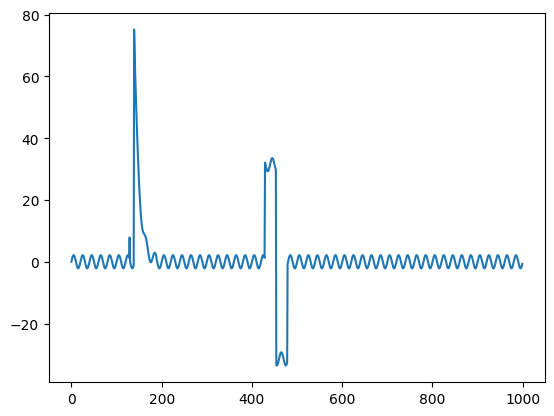

In [ ]:
plt.plot(signal["y"])

In [ ]:
intervals = intervals_errors(signal["y"])

cln_signal = clean_signal(signal)

for interval in intervals:
  error = cln_signal[interval[0] * 2: interval[1] * 2]

  result = optuna_classification_parallel(error)

  print(result)

['Bad signal', 'Nan']
['Bad signal', 'Nan']
['Bad signal', 'Nan']
['Invexp', 0.10352549181428645]
['Invexp', 14.360001196685511]
['Invexp', 6.805717979579696]
['Invexp', 34.29288619252341]
['haar', 46.30054736729688]
['haar', 36.84747488078865]
['Bad signal', 'Nan']
['Bad signal', 'Nan']
['Bad signal', 'Nan']
['Invexp', 4.772908534213416]
['Invexp', 8.73319177391148]
['Invexp', 24.377326064711806]
['haar', 32.03535212916239]
['Invexp', 60.028372884004725]
['Bad signal', 'Nan']
['Bad signal', 'Nan']
['Invexp', 3.6035362515448095]
['Invexp', 9.012028178448302]
['Invexp', 24.173558793490912]
['haar', 18.327191802160126]
['haar', 18.10256552062766]
['Bad signal', 'Nan']
['Invexp', 0.19477930389982817]
['Invexp', 2.9608049159786898]
['Invexp', 9.243036398221317]
['haar', 1.996681952215737]
['haar', 6.7878125494009565]
['Bad signal', 'Nan']
['Bad signal', 'Nan']
['Invexp', 9.057645061156764]
['haar', 1.4823894466332388]
['haar', 0.23999622654223687]
['Bad signal', 'Nan']
['Bad signal', 'Nan'

## Test 2

In [31]:
signal = create_multierror_dataset(2, 1)

In [32]:
signal

,x,y
0,0.000,0.000000
1,0.001,6.423993
2,0.002,12.219160
3,0.003,16.818232
4,0.004,19.771017
...,...,...
995,0.995,-20.788477
996,0.996,-19.770885
997,0.997,-16.818117
998,0.998,-12.218680


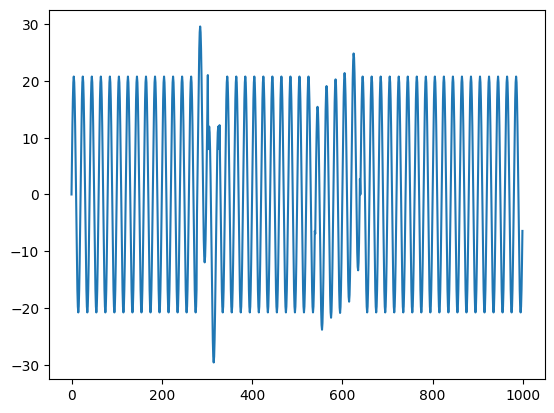

In [33]:
plt.plot(signal["y"])

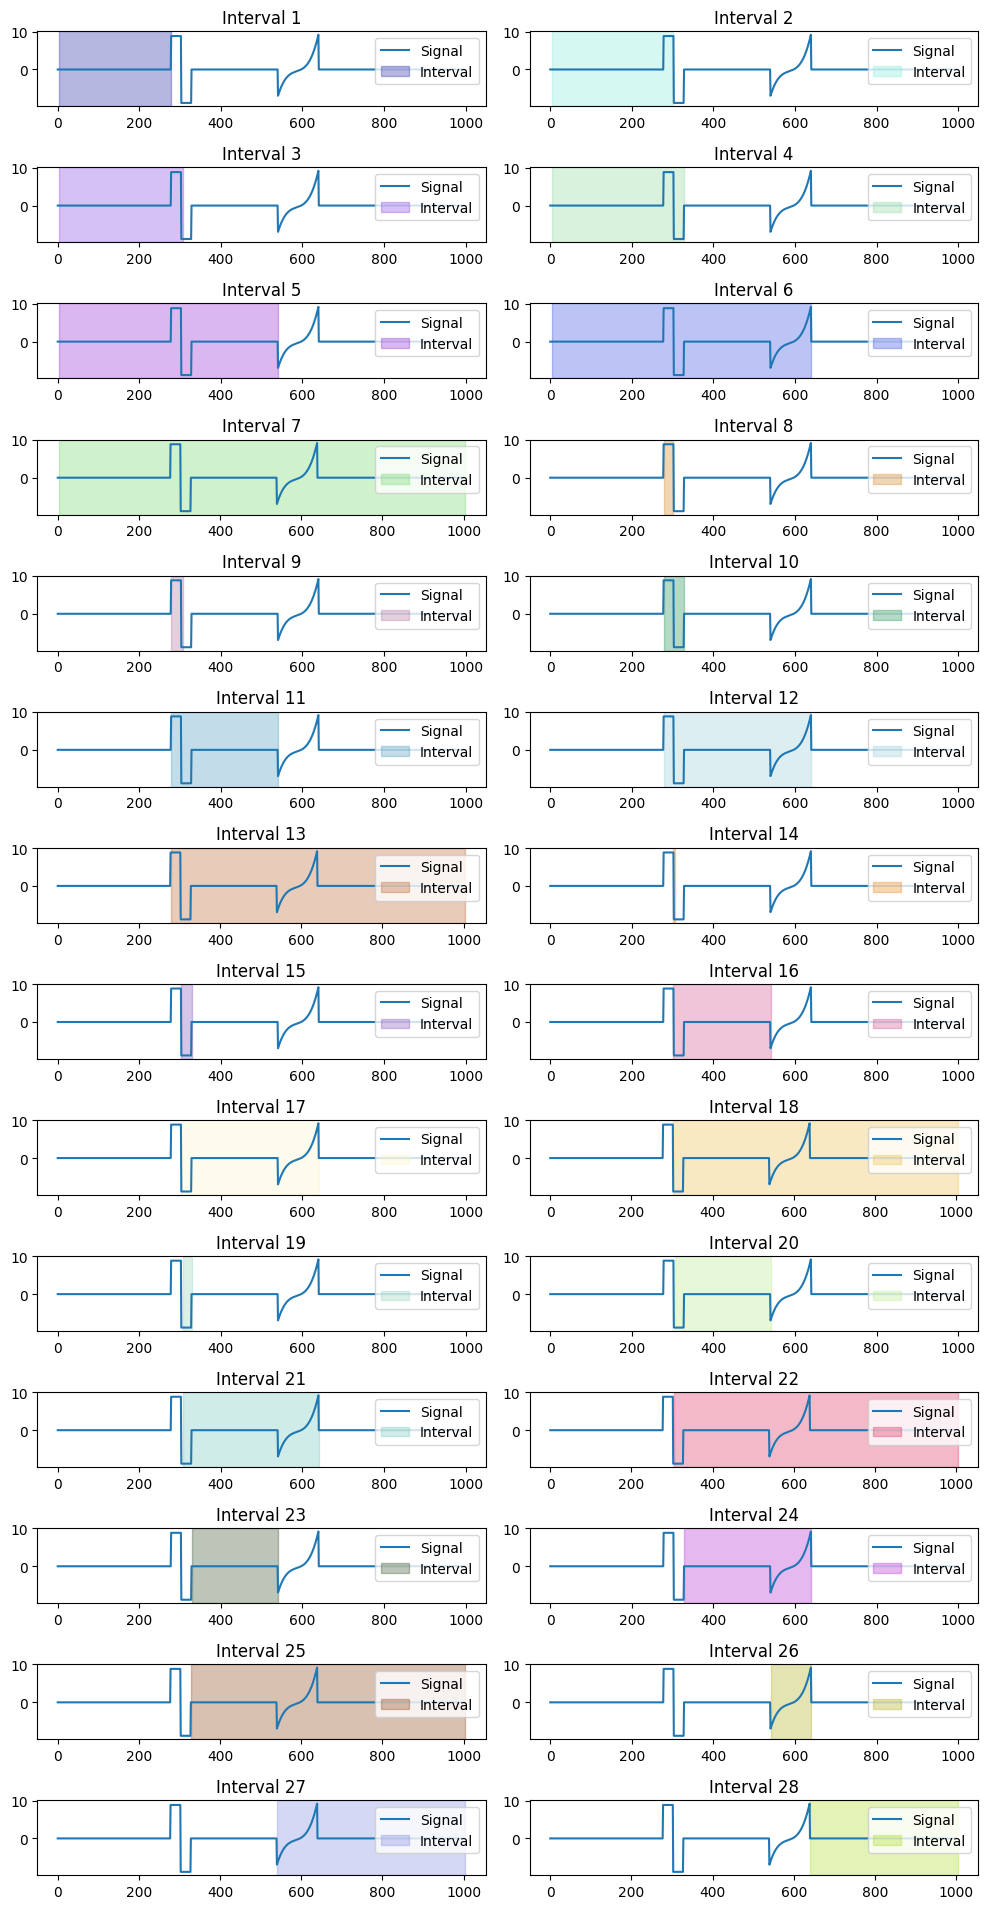

In [34]:
intervals = intervals_errors(signal["y"])

cln_signal = clean_signal(signal)

vis_errors_intervals(cln_signal, intervals, figsize=((10, 20)))

In [35]:
intervals = intervals_errors(signal["y"])

cln_signal = clean_signal(signal)

for interval in intervals:
  error = cln_signal[interval[0] * 2: interval[1] * 2]

  result = optuna_classification_parallel(error)

  print(result)

['Bad signal', 'Nan']
['Invexp', 0.7393461651184885]
['Invexp', 0.9270718678799129]
['haar', 0.4483986054248998]
['haar', 1.6442675100441768]
['haar', 1.662306992601506]
['haar', 1.2091992670280005]
['Bad signal', 'Nan']
['Bad signal', 'Nan']
['Bad signal', 'Nan']
['haar', 0.3828407690311128]
['haar', 1.5051482716649167]
['Invexp', 3.7848731497205654]
['Bad signal', 'Nan']
['Bad signal', 'Nan']
['Invexp', 0.6962349307477768]
['algb', 2.1415150133240552]
['Invexp', 1.9215688620257707]
['Bad signal', 'Nan']
['Invexp', 0.481172995368308]
['-exp', 1.90184301811751]
['Invexp', 1.6963876466953458]
['Bad signal', 'Nan']
['algb', 0.20909141407031565]
['algb', 3.1867313568958966e-13]
['algb', 0.25131261906566665]
['algb', 2.1742321591169556e-13]
['Bad signal', 'Nan']
